### The idea

The term fake news gained prominence during the last US election, but have been around for a while. The problem is that now they have saturated the media landscape with ever more scandalous titles, and have reached a point where it is difficult to tell the fake from real. They are widely used for political purposes and supposedly shaped the last US elections and are part of the widespread russian hybrid war. 

The goal of this "excercise" is to explore these fake news: Where do they come from? What is in them? What topics get the most involvement? Finally I will try to build a classifier that tries to tell fake from clickbait from real news, and a fake news generator, that will hopefully capture the essence

### Plan of attack 

1. Which media have the most fake news in the dataset?
    Looks like the way the dataset is constructed you get at most 100 titles from a media. So not the best metric        
2. What are the most common words and bigrams you find in titles? 
3. What are the most common words and bigrams you find in texts?
4. What topics get the most interest (likes, shares and comments)?:
    - Need to figure out how to determine topics.
5. Which medias get the most interest (likes, shares and comments)?
6. Can we build fake news classifier:
    - Need to get non-fake-news data.
    - Would it work by title only?
    - Classify fake news, clickbait, real_news
    - T-SNE, clustering and other visualisation. 
    - Word distributions in different groups
    - Deep vs traditional
    - word2vec vs. tf-idf
7. How often do capital letters appear in titles? Can we use these as a predictor?
8. What do the texts of the articles tell us - can we find common patterns, topics, etc.?
9. Can we build a fake news generator?
    - GAN? 
    - RNN or something?
10. Obtain more news to see if the set reflects current state of fake news media. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
# TODO - Stemming

In [2]:
n_samples = 2000
n_features = 1000
n_components = 8
n_top_words = 20

stopwords = list(set(stopwords.words('english')))
stopwords.extend(['-', '&', '|', 'hillary', 'clinton', 'trump', 'obama', 'http','https', 'share', 
                  'html','com', 'donald','Hillary', 'also', 'said', 'say',
                  'Obama', 'www', 'infowars', 'infowarsstore'])
sns.set()

In [3]:
def make_wordcloud(texts, stopwords, title="Wordcloud", plot=True):
    """
    Helper function that will plot a word cloud from a text or list of texts
    """
    if type(texts) is list:
        texts = ' '.join(texts)
    texts = texts.lower()
    wordcloud = WordCloud(max_font_size=50,
                          background_color="white",
                          max_words=2000,
    
                          stopwords=stopwords).generate(texts)
    if not plot:
        return wordcloud
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()
    

def print_top_words(model, feature_names, n_top_words):
    
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    
def get_topics(texts):
    
    
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                       max_features=n_features,
                                       stop_words=stopwords)
    tfidf = tfidf_vectorizer.fit_transform(texts)
    nmf = NMF(n_components=n_components, random_state=1,
              alpha=.1, l1_ratio=.5).fit(tfidf)

    print("\nTopics in NMF model (Frobenius norm):")
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    print_top_words(nmf, tfidf_feature_names, n_top_words)

In [4]:
# Prepare and clean data
data = pd.read_csv("fake.csv", header=0)
print(set(data.language))
print(set(data.type))
# We want only english on this one. Unfortunately reduces the dataset down to a third of its original size
data = data[data.language == 'english'] 
data = data.dropna()

{'arabic', 'english', 'polish', 'finnish', 'portuguese', 'german', 'russian', 'french', 'italian', 'chinese', 'norwegian', 'greek', 'ignore', 'dutch', 'turkish', 'spanish'}
{'fake', 'conspiracy', 'satire', 'hate', 'bias', 'junksci', 'bs', 'state'}


In [5]:
data.head()

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias


In [6]:
satire = data[data.type=='satire']
consp = data[data.type=='conspiracy']
state = data[data.type=='state']
bs = data[data.type=='bs']
bias = data[data.type=='bias']
fake = data[data.type=='fake']
junksci = data[data.type=='junksci']
hate = data[data.type=='hate']


### Dataset type composition

By far the most news are the ones labelled as 'bs'. Seems that this category is a throw it all that features a lot of data that would otherwise be in another category. Biased news, conspiracy theories, hate news and junkscience follow. Now the question here is how much does this distributon capture what is actually out there and is there a way to get an idea for that? I will try to come back to that later.

[('fake', 2), ('conspiracy', 163), ('hate', 99), ('bias', 271), ('junksci', 97), ('bs', 3737), ('state', 6)]


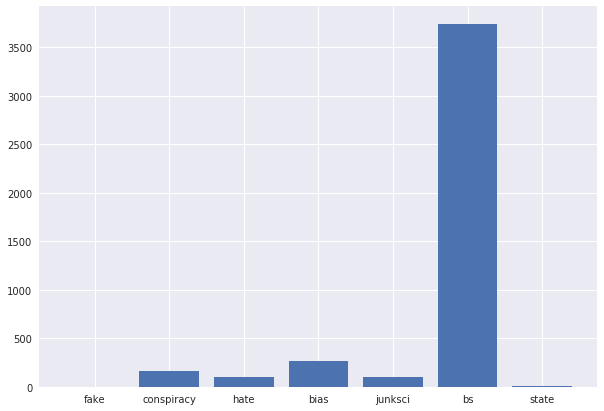

In [7]:
types = set(data.type)
sizes = []
for t in types:
    sizes.append((t, data[data.type==t].shape[0]))
print(sizes)

plt.figure(figsize=[10,7])
plt.bar(left = [x for x in range(len(types))], height = [x[1] for x in sizes])
plt.xticks([x for x in range(len(types))], [x[0] for x in sizes])
plt.show()

### Wordclouds

Lets have a look at the wordclouds of the texts of the news in the major categories. 
Initially all clouds had the names of the presidential candidates as well as former president Obama feature prominently.
So, I added them to the stopwords, to see what else is there. 

At a first glance most wordclouds feature some of the same prominent words, yet have their own slant. The junk
science news seem to stand on its own, as it features a lot more health related words. Most other 'fake news'
seem to be overly political. 

It seems there is quite the little marketing campaign going on in conspiracy. Might also be the case that most of those news come exclusively from infowars. 

Next step would be comparing word distributions and trying to do PCAs, clustering, etc. 



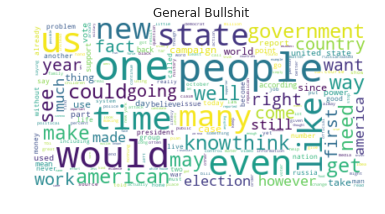

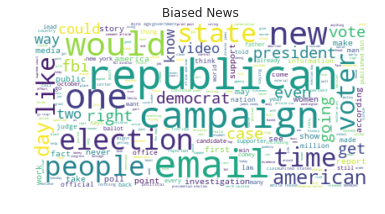

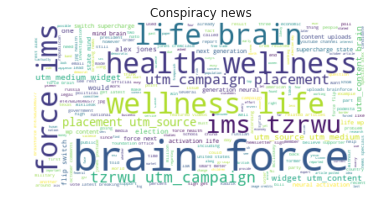

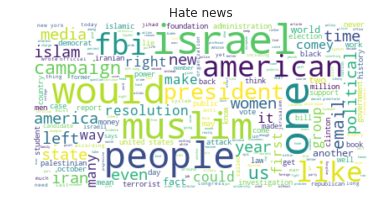

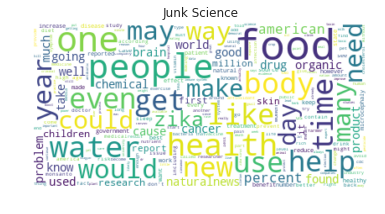

In [8]:
# 1. With and without names
# 2. texts and titles
make_wordcloud(list(bs.text), stopwords, "General Bullshit")
make_wordcloud(list(bias.text), stopwords, "Biased News")
make_wordcloud(list(consp.text), stopwords, "Conspiracy news")
make_wordcloud(list(hate.text), stopwords, "Hate news")
make_wordcloud(list(junksci.text), stopwords, "Junk Science")

#TODO Put all in one graph. 

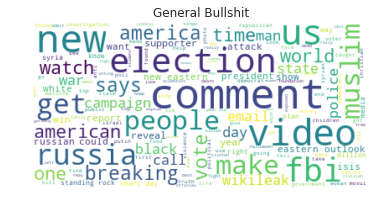

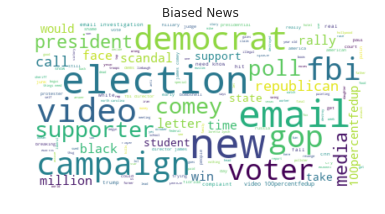

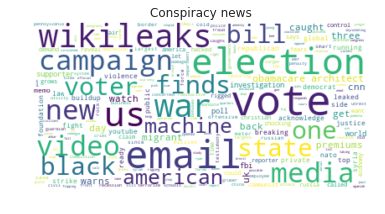

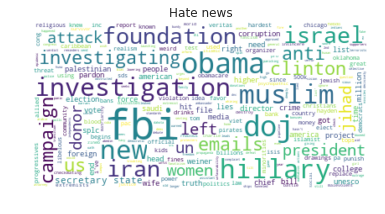

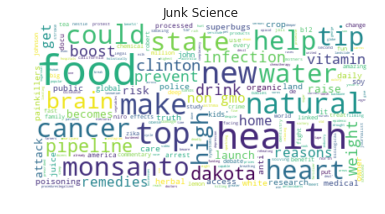

In [9]:
make_wordcloud(list(bs.title), stopwords, "General Bullshit")
make_wordcloud(list(bias.title), stopwords, "Biased News")
make_wordcloud(list(consp.title), stopwords, "Conspiracy news")
make_wordcloud(list(hate.title), stopwords, "Hate news")
make_wordcloud(list(junksci.title), stopwords, "Junk Science")

In [10]:
# likes and shares. 
shared_data = data[['uuid', 'site_url', 'likes', 'shares', 'comments']]

#shared_data_counts = shared_data_counts[ (shared_data_counts.likes>0) | (shared_data_counts.shares > 0)]
#share_data_counts
shared_data.head()

,uuid,site_url,likes,shares,comments
0,6a175f46bcd24d39b3e962ad0f29936721db70db,100percentfedup.com,0,0,0
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,100percentfedup.com,0,0,0
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,100percentfedup.com,0,0,0
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,100percentfedup.com,0,0,0
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,100percentfedup.com,0,0,0


Index(['likes', 'shares', 'comments'], dtype='object')


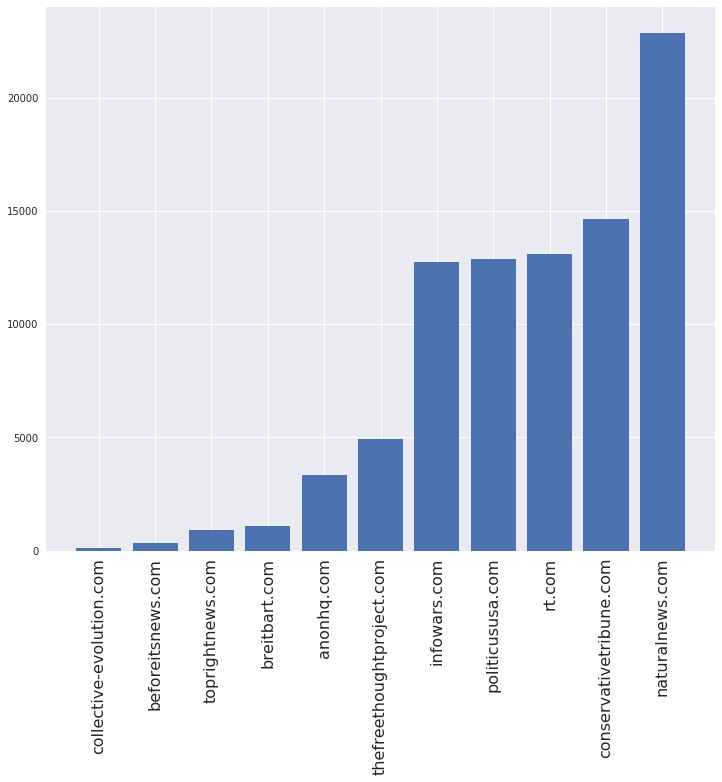

In [11]:
shared_data = shared_data[(shared_data.likes>0) | (shared_data.shares>0) | (shared_data.comments>0)]
shared_data_counts = shared_data.groupby('site_url').sum().sort_values(by=['shares'])
print(shared_data_counts.columns)
# Weird that likes and share are exactly the same number
plt.figure(figsize=(12,10))
plt.bar(left=[x for x in range(len(shared_data_counts.likes))], height = list(shared_data_counts.shares))
plt.xticks([x for x in range(len(shared_data_counts.likes))], list(shared_data_counts.index), rotation="vertical", fontsize=16)
plt.show()

Overall I don't think the topics given in the type column in the dataset are very good. 
Next Im going to try extracting a new set of topics, as described over here: 
http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py in sci-kit learn. 

In [12]:
n_samples = 2000
n_features = 1000
n_components = 9
n_top_words = 20

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    
def get_topics(texts):
    
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                       max_features=n_features,
                                       stop_words=stopwords)
    tfidf = tfidf_vectorizer.fit_transform(texts)
    nmf = NMF(n_components=n_components, random_state=1,
              alpha=.1, l1_ratio=.5).fit(tfidf)

    print("\nTopics in NMF model (Frobenius norm):")
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    print_top_words(nmf, tfidf_feature_names, n_top_words)

In [13]:
#Initial NMF run
"""
Topics in NMF model (Frobenius norm):
Topic #0: people one would like world time us even many right years know get could government year way see president make
Topic #1: fbi comey investigation emails weiner director letter abedin james server information department huma election justice congress case agents evidence federal
Topic #2: russia russian syria us war military putin isis nato syrian nuclear mosul forces iraq china al foreign government civilians saudi
Topic #3: election vote voting voters voter republican percent votes party democrats polls campaign republicans fraud poll presidential win candidate states elections
Topic #4: october 2016 https 27 twitter 28 pic co 26 posted 29 share video november news campaign wednesday cnn watch says
Topic #5: police pipeline dakota water standing rock protesters officers north access native enforcement officer land camp county law protest state department
Topic #6: david daily november day state data 2016 leading mainstream latest governments posted place violence available markets email financial well world
Topic #7: health cancer food brain body water study disease foods medical blood research dr found effects studies natural products heart levels
Topic #8: email podesta campaign emails wikileaks john new via private follow 2015 server please comments account running secretary twitter released state
"""

'\nTopics in NMF model (Frobenius norm):\nTopic #0: people one would like world time us even many right years know get could government year way see president make\nTopic #1: fbi comey investigation emails weiner director letter abedin james server information department huma election justice congress case agents evidence federal\nTopic #2: russia russian syria us war military putin isis nato syrian nuclear mosul forces iraq china al foreign government civilians saudi\nTopic #3: election vote voting voters voter republican percent votes party democrats polls campaign republicans fraud poll presidential win candidate states elections\nTopic #4: october 2016 https 27 twitter 28 pic co 26 posted 29 share video november news campaign wednesday cnn watch says\nTopic #5: police pipeline dakota water standing rock protesters officers north access native enforcement officer land camp county law protest state department\nTopic #6: david daily november day state data 2016 leading mainstream late

Ok, so now that is done the topics we get here are very different from the typology presented in the dataset. 
Indeed they are actual topics covered in the dataset. We see that the Clinton e-mail scandal features on its own 
in two different topics - one that covers a more legal stance and one that focuses more on the scandal itself.
The Syrian civil war is there, and so is the Dacota pipeline as well as a topic related to health. What does not
emerge here is whether these are bias or hate or conspiracy focused,
and perhaps each shares a substantial number of articles(TODO).
One of the topic has a lot of words that suggest some cleanup is in order. 

The major take-away is that fake-news seem to follow the scandals and important events of the 
day and seem to connect with them. An exception to this would be the natural news topics, which would follow 
its own niche that does not necessary reflect the big news. 

We can in fact do the same topic analysis on each of the subgroups of fake news we have. 

In [14]:
get_topics(junksci.text)


Topics in NMF model (Frobenius norm):
Topic #0: water lemon juice body health drink tea heart cholesterol garlic pain oil skin help day brain kidney disease blood weight
Topic #1: election america criminal clintons media vote democracy democrats political news power government corruption steal pretend democrat establishment fraud cnn people
Topic #2: food organic waste china drought packaging farmers water percent chinese workers million chemicals feed california people fresh many economic community
Topic #3: cancer chemotherapy women breast ovarian johnson onions found researchers hospitals study medical cells percent treatment rate medicine would survival patients
Topic #4: vitamin spinach carrots inflammation vitamins magnesium sources omega fight minerals levels raw cooked carrot antioxidant tomatoes beta rich cooking body
Topic #5: gmo corn products non crop monsanto gm farmers crops product ingredients company industry project little water consumers really state public
Topic #6:

In [15]:
get_topics(bs.text)


Topics in NMF model (Frobenius norm):
Topic #0: people one like would many time even us world get years could right make way know year government much first
Topic #1: fbi comey investigation emails weiner director abedin letter huma server james information department agents congress case election justice federal former
Topic #2: russia russian syria us war military putin isis syrian nuclear mosul nato forces iraq china government saudi foreign western al
Topic #3: election vote voting voters voter republican party votes campaign fraud democrats president percent candidate polls win presidential states elections democratic
Topic #4: october 2016 27 twitter 28 pic co 26 29 posted november video news right campaign says facebook left get oct
Topic #5: david daily november day state 2016 data leading latest mainstream governments posted violence available place markets financial well email wednesday
Topic #6: police pipeline dakota water standing rock protesters north officers access nat

In [16]:
get_topics(bias.text)


Topics in NMF model (Frobenius norm):
Topic #0: facebook account comment via article disqus follow us times political wrong wing media elect popular go officer history new york
Topic #1: campaign election president voters republican republicans 2016 would women like presidential people news one get states going nominee vote new
Topic #2: comey fbi emails letter investigation director republicans email election james information server new scandal congress department partisan hatch secretary complaint
Topic #3: found period dead israel woman century old inside ago home officers published year york police told mins nypd authority three
Topic #4: percent points data poll support 22 economic showed lead market mins published wednesday 20 holding continued ago florida losing 100
Topic #5: sheriff judge joe weeks term case federal court two ago district charges charge criminal signed months five days election nov
Topic #6: david century host events bible archive yes others god data known re

In [17]:
get_topics(hate.text)


Topics in NMF model (Frobenius norm):
Topic #0: fbi comey investigation lynch campaign emails director james investigating attorney weiner election department media attack letter doj abedin server standard
Topic #1: left president people one like would american black america us media political could money time white new two first election
Topic #2: israel resolution palestinian jerusalem israeli unesco jewish pa palestinians anti nations muslim netanyahu council us palestine security russia body arab
Topic #3: muslim muslims islam jihad religious splc list islamic christians tests cair muhammad allah isis hirsi religion brotherhood american terror ali
Topic #4: biden joe iran secretary iranian state senator bush fund make 200 million check obvious terrorists would big administration islamic want
Topic #5: states united un cuba resolution policy ambassador cuban embargo communist america us rhodes voted rights power human castro regime defend
Topic #6: percent republicans early points 

###